In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import get_power_plants
from geodata_processing import download_gdf
import numpy

In [2]:
USA = download_gdf(country='USA',resolution=1)

CA_boundary = USA[USA.NAME_1=='California'].geometry

In [3]:
from shapely.geometry import Point
import random

def generate_random_coordinates_within_multipolygon(pol, num_points):
    points = []
    multipolygon = pol.bounds.to_numpy()
    min_x, min_y, max_x, max_y = multipolygon[0]
    while len(points) < num_points:
        random_point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if pol.contains(random_point).iloc[0]:
            points.append((random_point.x, random_point.y))
    return points

random_points = generate_random_coordinates_within_multipolygon(CA_boundary, 1000)


In [4]:
CA = get_power_plants.get_uspvdb('CA')

In [5]:
known_plants = CA[['xlong','ylat']].to_numpy()

In [22]:
from shapely.geometry import Point
from geopandas.tools import sjoin
import geopandas as gpd
import random

npoints = 600
from shapely.geometry import Point
import random
import geopandas as gpd
from shapely.geometry import Polygon

def generate_random_coordinates_within_multipolygon_and_filter(pol, set_A, distance_threshold_km, num_points_each=500):
    points_within = []
    points_outside = []

    # Buffer set_A by the distance threshold
    set_A_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in set_A], crs="EPSG:4326")
    set_A_gdf = set_A_gdf.to_crs(epsg=3857)  # Convert to a metric system (meters)
    set_A_gdf['geometry'] = set_A_gdf.buffer(distance_threshold_km * 1000)  # Buffer in meters

    multipolygon = pol.bounds.to_numpy()
    min_x, min_y, max_x, max_y = multipolygon[0]

    while len(points_within) < num_points_each or len(points_outside) < num_points_each:
        random_point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))

        # Check if the point is within the multipolygon
        if pol.contains(random_point).iloc[0]:
            # Convert the point to the same CRS as the buffered set_A
            random_point_gdf = gpd.GeoDataFrame(geometry=[random_point], crs="EPSG:4326").to_crs(epsg=3857)

            # Check if the point is within the buffer zone of set_A
            within_set_A = set_A_gdf.contains(random_point_gdf.iloc[0].geometry).any()

            if within_set_A and len(points_within) < num_points_each:
                points_within.append((random_point.x, random_point.y))
            elif not within_set_A and len(points_outside) < num_points_each:
                points_outside.append((random_point.x, random_point.y))

    return points_within, points_outside

# Example usage
# Assuming 'CA_boundary' is your multipolygon and 'known_plants' is a list of (x, y) tuples representing coordinates

distance_threshold_km = 10  # 10 km threshold
points_within, points_outside = generate_random_coordinates_within_multipolygon_and_filter(CA_boundary, known_plants, distance_threshold_km)

# Now you have 500 points within set A and 500 points not within set A

In [26]:
len(points_outside)

500

In [27]:
points_within_df = pd.DataFrame(points_within, columns=['Longitude', 'Latitude'])
points_outside_df = pd.DataFrame(points_outside, columns=['Longitude', 'Latitude'])

# Add labels
points_within_df['have_plant'] = 1
points_outside_df['have_plant'] = 0

combined_df = pd.concat([points_within_df, points_outside_df], ignore_index=True)

In [28]:
combined_df

,Longitude,Latitude,have_plant
0,-121.725484,37.173490,1
1,-121.679490,37.896485,1
2,-120.697811,35.341921,1
3,-120.394202,36.826376,1
4,-121.568344,38.714189,1
...,...,...,...
995,-123.924907,40.166934,0
996,-119.548718,37.672683,0
997,-121.227562,38.023947,0
998,-123.501468,41.532099,0


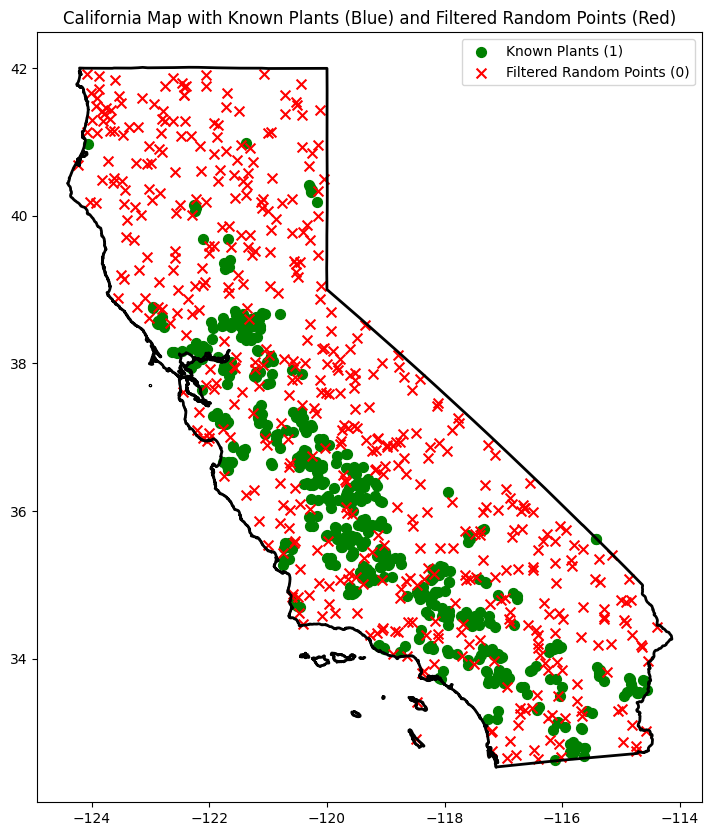

In [31]:
# Function to plot the combined DataFrame on a map
def plot_combined_df_on_map(combined_df):

    # Convert the combined DataFrame to a GeoDataFrame
    combined_gdf = geopandas.GeoDataFrame(
        combined_df, geometry=geopandas.points_from_xy(combined_df.Longitude, combined_df.Latitude), crs="EPSG:4326"
    )

    # Create a GeoDataFrame for California
    california_gdf = geopandas.GeoDataFrame(geometry=[CA_boundary.iloc[0]], crs="EPSG:4326")

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)

    # Plot known plants (Label = 1) with a different marker
    combined_gdf[combined_gdf['have_plant'] == 1].plot(ax=ax, color='green', marker='o', label='Known Plants (1)', markersize=50)

    # Plot filtered random points (Label = 0) with a different marker
    combined_gdf[combined_gdf['have_plant'] == 0].plot(ax=ax, color='red', marker='x', label='Filtered Random Points (0)', markersize=50)

    # Add labels and legend
    plt.title('California Map with Known Plants (Blue) and Filtered Random Points (Red)')
    plt.legend()

    # Show plot
    plt.show()

plot_combined_df_on_map(combined_df)
combined_df.to_csv('CA_locations_balanced_1000.csv')

In [30]:
combined_df

,Longitude,Latitude,have_plant
0,-121.725484,37.173490,1
1,-121.679490,37.896485,1
2,-120.697811,35.341921,1
3,-120.394202,36.826376,1
4,-121.568344,38.714189,1
...,...,...,...
995,-123.924907,40.166934,0
996,-119.548718,37.672683,0
997,-121.227562,38.023947,0
998,-123.501468,41.532099,0


In [6]:
from shapely.geometry import Point
from geopandas.tools import sjoin
import random

def filter_coordinates_by_distance_gdf(random_points, set_A, distance_threshold_km):
    # Convert random_points and set_A into GeoDataFrames
    random_points_gdf = geopandas.GeoDataFrame(geometry=[Point(xy) for xy in random_points])
    set_A_gdf = geopandas.GeoDataFrame(geometry=[Point(xy) for xy in set_A])

    # Buffer set_A by the distance threshold
    set_A_gdf = set_A_gdf.set_crs(epsg=4326)  # Assuming the coordinates are in WGS84
    set_A_gdf = set_A_gdf.to_crs(epsg=3857)   # Convert to a metric system (meters)
    set_A_gdf['geometry'] = set_A_gdf.buffer(distance_threshold_km * 1000)  # Buffer in meters

    # Convert random points to the same CRS
    random_points_gdf = random_points_gdf.set_crs(epsg=4326)
    random_points_gdf = random_points_gdf.to_crs(epsg=3857)

    # Perform a spatial join to find random points within the buffer zones
    joined_gdf = sjoin(random_points_gdf, set_A_gdf, how="left", op="within")

    # Filter out points that are within the distance threshold (those with a match in set_A)
    filtered_gdf = joined_gdf[joined_gdf.index_right.isna()]

    # Convert filtered points back to EPSG:4326 (latitude, longitude)
    filtered_gdf = filtered_gdf.to_crs(epsg=4326)

    # Convert filtered points back to a list of tuples (x, y)
    filtered_points = [(point.x, point.y) for point in filtered_gdf.geometry]

    return filtered_points

# Example usage
# Assuming 'set_A' is a list of tuples (x, y) representing 500 separate coordinates
# And 'random_points' is the list of random coordinates generated earlier

distance_threshold_km = 10  # 10 km threshold
filtered_random_points = filter_coordinates_by_distance_gdf(random_points, known_plants, distance_threshold_km)


/Users/kaorukure/.pyenv/versions/3.10.6/envs/illuminating_horizons/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
len(filtered_random_points)

893

In [96]:
absent_points = random.sample(filtered_random_points,len(known_plants))

In [97]:

known_plants_df = pd.DataFrame(known_plants, columns=['Longitude', 'Latitude'])
#absent_points_df = pd.DataFrame(absent_points, columns=['Longitude', 'Latitude'])
absent_points_df = pd.DataFrame(filtered_random_points, columns=['Longitude', 'Latitude'])


# Add labels
known_plants_df['have_plant'] = 1
absent_points_df['have_plant'] = 0

# Concatenate the DataFrames
combined_df = pd.concat([known_plants_df, absent_points_df], ignore_index=True)


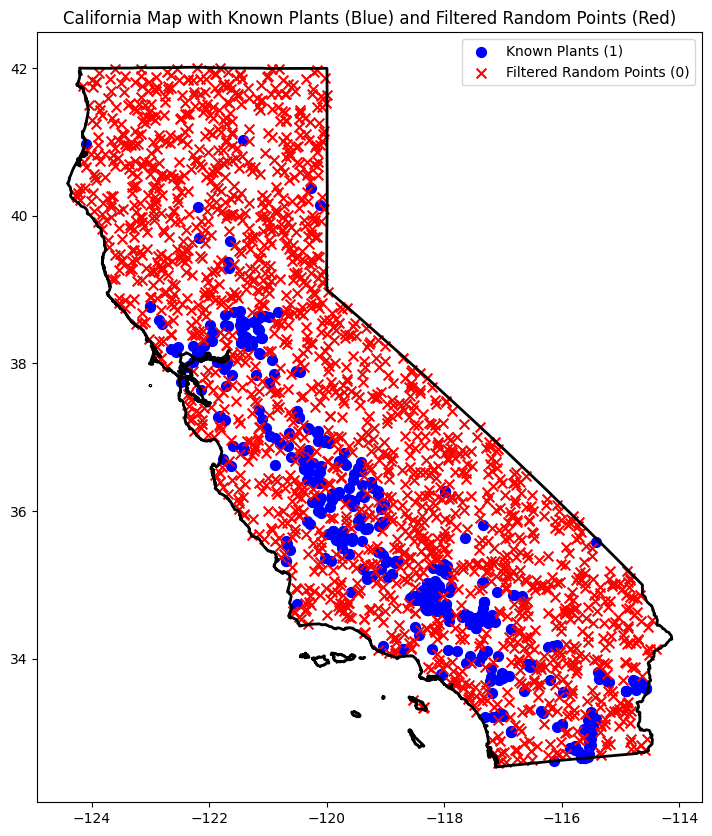

In [98]:
# Function to plot the combined DataFrame on a map
def plot_combined_df_on_map(combined_df):

    # Convert the combined DataFrame to a GeoDataFrame
    combined_gdf = geopandas.GeoDataFrame(
        combined_df, geometry=geopandas.points_from_xy(combined_df.Longitude, combined_df.Latitude), crs="EPSG:4326"
    )

    # Create a GeoDataFrame for California
    california_gdf = geopandas.GeoDataFrame(geometry=[CA_boundary.iloc[0]], crs="EPSG:4326")

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)

    # Plot known plants (Label = 1) with a different marker
    combined_gdf[combined_gdf['have_plant'] == 1].plot(ax=ax, color='blue', marker='o', label='Known Plants (1)', markersize=50)

    # Plot filtered random points (Label = 0) with a different marker
    combined_gdf[combined_gdf['have_plant'] == 0].plot(ax=ax, color='red', marker='x', label='Filtered Random Points (0)', markersize=50)

    # Add labels and legend
    plt.title('California Map with Known Plants (Blue) and Filtered Random Points (Red)')
    plt.legend()

    # Show plot
    plt.show()

plot_combined_df_on_map(combined_df)


In [99]:
combined_df.to_csv('CA_locations_2000.csv')

In [100]:
combined_df

,Longitude,Latitude,have_plant
0,-120.109391,36.177598,1
1,-116.327979,33.265240,1
2,-118.304671,34.707428,1
3,-118.274109,34.708588,1
4,-120.115552,36.175836,1
...,...,...,...
2310,-118.896501,36.718088,0
2311,-119.133723,36.125849,0
2312,-122.722559,39.423085,0
2313,-118.025948,34.326249,0


In [109]:
import requests
import pandas as pd
import io

# You must request an NSRDB api key from the link above
api_key = 'KNcuq3quebkAaHWTsVbvD8RGxK5U7XVZyt9W1W6k'
# Your full name, use '+' instead of spaces.
name = 'Kaoru+Kure'
# Your affiliation
affiliation = 'LeWagon'
# Your email address
email = 'kurekaoru@gmail.com'




def get_ghi_data(lat, lon, year, api_key,i):
    """
    Fetches GHI data from the NSRDB for the specified location and year.

    Parameters:
    - lat: Latitude of the location.
    - lon: Longitude of the location.
    - year: Year for which to retrieve the data.
    - api_key: Your NSRDB API key.

    Returns:
    - A DataFrame with the GHI data for the specified location and year.
    """
    url = f'https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv'

    params = {
        'api_key': api_key,
        'wkt': f"POINT({lon} {lat})",
        'names': year,
        'interval': '60',
        'full_name': 'Your Name',
        'email': email,
        'affiliation': affiliation,
        'reason': 'testing',
        'attributes': 'ghi,dni,dhi,clearsky_ghi,clearsky_dni,clearsky_dhi,solar_zenith_angle,air_temperature'
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        df = pd.read_csv(io.StringIO(response.text), skiprows=2)
        df.to_csv(f'{year}_{i}_radiance.csv')
        return df
    else:
        print(f"Error fetching data for {lat}, {lon}: {response.status_code}")
        return None


In [110]:
import sqlite3
import pandas as pd

# Get one unfinished task from DB
def getTask(years = None):
    conn = sqlite3.connect('download_tracker.sql')
    query = 'SELECT YEAR, POINT FROM files WHERE DONE = 0 limit 1'
    if years is not None:
        if type(years) == int:
            years = [years]
        yearstr = ','.join([str(y) for y in years])
        query = f'SELECT YEAR, POINT FROM files WHERE year IN ({yearstr}) AND DONE = 0 limit 1'
    task = pd.read_sql_query(query,conn)
    return task

# Mark task as done after download is complete
def writeTask(year, point):
    conn = sqlite3.connect('download_tracker.sql')
    c = conn.cursor()
    query = f'UPDATE FILES SET DONE = 1 WHERE YEAR = {year} AND POINT = {point}'
    c.execute(query)
    conn.commit()
    conn.close()
    print(f'Completed record y:{year}, p:{point}')


In [30]:
#conn = sqlite3.connect('download_tracker.sql')
#points = pd.read_csv('CA_locations_2000.csv')
#points.columns=['I','Longitude','Latitude','have_plant']
#points.to_sql('POINTS', conn, index=False, if_exists='replace')
#conn = sqlite3.connect('download_tracker.sql')

2315

In [216]:
import glob

years = [2014]

conn = sqlite3.connect('download_tracker.sql')

task = getTask(years)
while task.shape[0]>0:
    year, pid = getTask(years).to_numpy()[0]
    LAT, LON =  pd.read_sql_query(f'SELECT Latitude, longitude FROM points WHERE I = {pid}',conn).to_numpy()[0]
    #print(LAT, LON, year, api_key,pid)
    get_ghi_data(LAT, LON, year, api_key,pid)
    #check if the file is here
    chk = glob.glob(f'./{year}_{pid}_radiance.csv')
    if len(chk) > 0:
        print('file check Confirmed',chk[0])
        writeTask(year, pid)
    else:
        print('file check Failed')
        break
    #Get new task
    task = getTask(years)

file check Confirmed ./2014_716_radiance.csv
Completed record y:2014, p:716


In [219]:
def percentComplete():
    conn = sqlite3.connect('download_tracker.sql')
    done = pd.read_sql_query(f'SELECT count(*) from files where done = 1',conn).to_numpy()[0][0]
    mada = pd.read_sql_query(f'SELECT count(*) from files where done = 0',conn).to_numpy()[0][0]
    print(done/(done+mada)*100,'percent completed')

In [224]:
percentComplete()

98.54898880816808 percent completed


In [43]:
combined_df.iloc[0][['Latitude','Longitude']].to_numpy()

array([  36.177598, -120.109391])

In [44]:
ghi_data

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)
0,2015,1,1,0,30,5,21,411,47,1,...,47,58.61,86.32,0.144,1000,0.368,334.9,1.5,0.0000,0.0000
1,2015,1,1,1,30,3,0,0,0,1,...,0,62.59,97.02,0.144,1000,0.391,328.9,1.8,0.0000,0.0000
2,2015,1,1,2,30,2,0,0,0,1,...,0,68.55,108.42,0.144,1000,0.413,320.0,1.8,0.0000,0.0000
3,2015,1,1,3,30,2,0,0,0,1,...,0,69.74,120.27,0.144,1000,0.430,305.8,1.7,0.0000,0.0000
4,2015,1,1,4,30,1,0,0,0,4,...,0,74.63,132.34,0.144,1000,0.441,293.6,1.6,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2015,12,31,19,30,12,79,896,530,0,...,530,47.49,59.76,0.160,1000,0.799,82.8,0.5,29.2604,22.8564
8756,2015,12,31,20,30,13,79,901,535,0,...,535,42.51,59.57,0.160,1000,0.770,121.1,0.7,29.5689,23.0998
8757,2015,12,31,21,30,13,86,839,471,0,...,471,38.37,62.67,0.160,1000,0.741,120.7,0.8,25.5369,19.9122
8758,2015,12,31,22,30,12,75,777,358,0,...,358,40.20,68.60,0.160,1000,0.717,105.6,0.7,18.5537,14.3917


In [69]:
gd2 = ghi_data.drop(columns=['Relative Humidity','Dew Point','Wind Speed','Wind Direction','Precipitable Water','Surface Albedo','Year','Month','Day','Hour','Minute','Pressure','Cloud Type','Fill Flag','Global Horizontal UV Irradiance (280-400nm)','Global Horizontal UV Irradiance (295-385nm)'])

In [226]:
def chkFolder():
    folders = sorted(glob.glob('/Users/kaorukure/code/mashafif/illuminating_horizons/raw_data/radiance/*'))
    for f in folders:
        print(f.split('/')[-1],len(glob.glob(f'{f}/*.csv')))

chkFolder()

1999 2315
2000 2315
2001 2315
2002 2315
2003 2315
2004 2315
2005 2315
2006 2315
2007 2315
2008 2315
2009 2315
2010 2315
2011 1580
2012 2315
2013 2315
2014 2315
2015 2315
2016 2315
2017 2315
2018 2315
2019 2315
2020 2315


In [70]:
import seaborn as sns

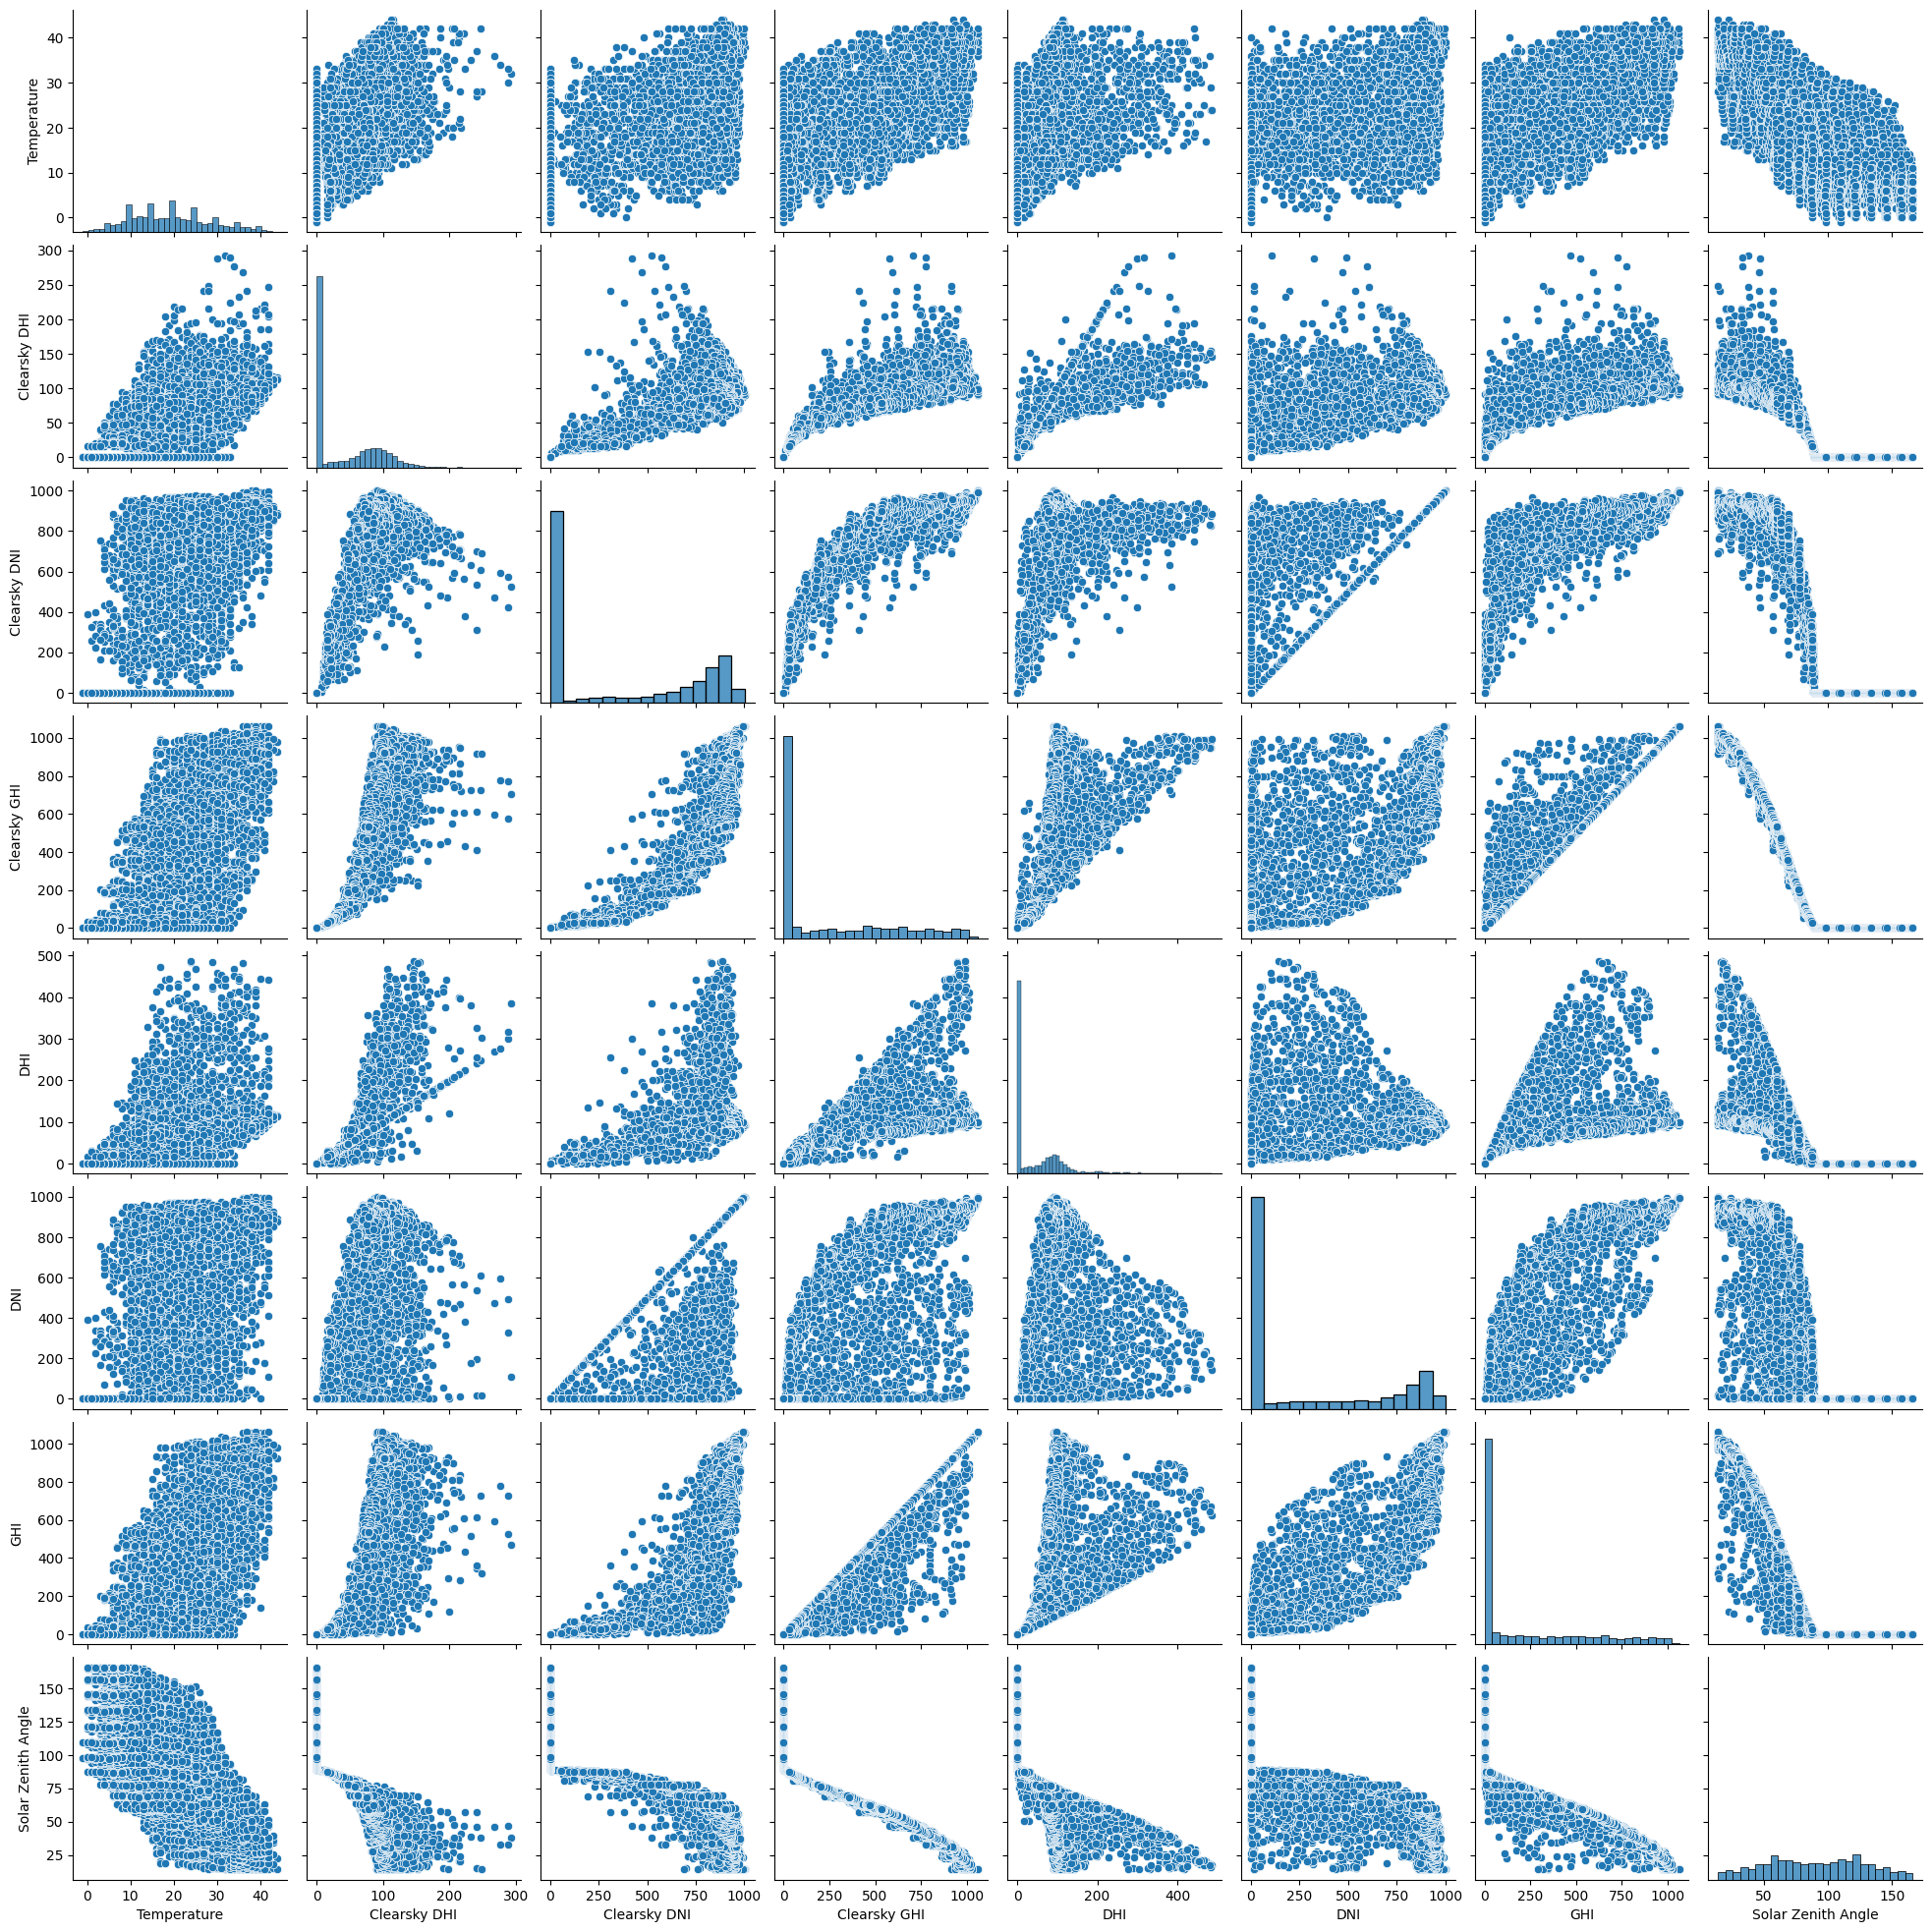

In [71]:
sns.pairplot(gd2)

In [ ]:
def fetch_ghi_for_combined_df(combined_df, year, api_key):
    """
    Fetches GHI data for each point in the combined DataFrame.

    Parameters:
    - combined_df: DataFrame containing the latitude and longitude of the points.
    - year: Year for which to retrieve the data.
    - api_key: Your NSRDB API key.

    Returns:
    - A dictionary where the key is a tuple (lat, lon) and the value is the GHI DataFrame.
    """
    ghi_data_dict = {}

    for index, row in combined_df.iterrows():
        lat, lon = row['Latitude'], row['Longitude']
        ghi_data = get_ghi_data(lat, lon, year, api_key)
        if ghi_data is not None:
            ghi_data_dict[(lat, lon)] = ghi_data

    return ghi_data_dict

# Example usage
year = 2023

ghi_data_dict = fetch_ghi_for_combined_df(combined_df, year, api_key)